In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 15 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 14 # the number of class
        self.feat_d = 105
        self.filters = 16
        self.data_dir = '/mnt/nasbi/homes/fan/projects/action/skeleton/data/JHMDB/'
C = Config()

In [4]:
random.seed(123)

def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))): 
        p = np.copy(T['pose'][i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
        p = normlize_range(p)

        label = np.zeros(C.clc_num)
        label[le.transform(T['label'])[i]-1] = 1   

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
    return X_0,X_1,Y

# Building the model

In [11]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,:1,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=16,joint_n=15,joint_d=2,feat_d=91,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = block(x,filters)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = block(x_d_slow,filters)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = block(x_d_fast,filters) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    
    x = block(x,filters*8)
    
    return Model(inputs=[M,P],outputs=x)


def build_AR_single(C):
    M = Input(name='M', shape=(C.frame_l,C.feat_d))  
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [12]:
AR_single = build_AR_single(C)
AR_single.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 105)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 15, 2)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 4, 128)       115424      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 128)          0           model_3[1][0]                    
__________

## Train and test on GT_split 1

In [13]:
Train = pickle.load(open(C.data_dir+"GT_train_1.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"GT_test_1.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 176/176 [00:00<00:00, 280.75it/s]


In [14]:
import keras
lr = 1e-3
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history=AR_single.fit([X_0,X_1],Y,
        batch_size=len(Y),
        epochs=600,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_test_0,X_test_1],Y_test)      
        )

Train on 433 samples, validate on 176 samples
Epoch 1/600
433/433 [==============================] - 10s 23ms/step - loss: 3.1749 - acc: 0.0808 - val_loss: 2.5942 - val_acc: 0.0966
Epoch 2/600
433/433 [==============================] - 0s 236us/step - loss: 3.0331 - acc: 0.1016 - val_loss: 2.4638 - val_acc: 0.1761
Epoch 3/600
433/433 [==============================] - 0s 197us/step - loss: 2.9405 - acc: 0.1085 - val_loss: 2.3548 - val_acc: 0.2102
Epoch 4/600
433/433 [==============================] - 0s 170us/step - loss: 2.7845 - acc: 0.1363 - val_loss: 2.2855 - val_acc: 0.2614
Epoch 5/600
433/433 [==============================] - 0s 176us/step - loss: 2.6237 - acc: 0.1501 - val_loss: 2.2182 - val_acc: 0.2898
Epoch 6/600
433/433 [==============================] - 0s 169us/step - loss: 2.5770 - acc: 0.1778 - val_loss: 2.1583 - val_acc: 0.3125
Epoch 7/600
433/433 [==============================] - 0s 159us/step - loss: 2.5010 - acc: 0.2379 - val_loss: 2.1001 - val_acc: 0.3295
Epoch 8/6

Epoch 61/600
433/433 [==============================] - 0s 166us/step - loss: 0.7020 - acc: 0.8083 - val_loss: 1.1681 - val_acc: 0.6023
Epoch 62/600
433/433 [==============================] - 0s 169us/step - loss: 0.6688 - acc: 0.7968 - val_loss: 1.1739 - val_acc: 0.6193
Epoch 63/600
433/433 [==============================] - 0s 158us/step - loss: 0.6313 - acc: 0.8314 - val_loss: 1.1841 - val_acc: 0.6136
Epoch 64/600
433/433 [==============================] - 0s 168us/step - loss: 0.6202 - acc: 0.8199 - val_loss: 1.1892 - val_acc: 0.6136
Epoch 65/600
433/433 [==============================] - 0s 168us/step - loss: 0.6217 - acc: 0.8152 - val_loss: 1.1925 - val_acc: 0.6023
Epoch 66/600
433/433 [==============================] - 0s 161us/step - loss: 0.6138 - acc: 0.8314 - val_loss: 1.2044 - val_acc: 0.6080
Epoch 67/600
433/433 [==============================] - 0s 173us/step - loss: 0.5946 - acc: 0.8222 - val_loss: 1.2141 - val_acc: 0.5966
Epoch 68/600
433/433 [==========================

433/433 [==============================] - 0s 143us/step - loss: 0.1928 - acc: 0.9607 - val_loss: 1.0477 - val_acc: 0.6705
Epoch 122/600
433/433 [==============================] - 0s 168us/step - loss: 0.1827 - acc: 0.9515 - val_loss: 1.0587 - val_acc: 0.6705
Epoch 123/600
433/433 [==============================] - 0s 164us/step - loss: 0.1726 - acc: 0.9654 - val_loss: 1.0650 - val_acc: 0.6705
Epoch 124/600
433/433 [==============================] - 0s 150us/step - loss: 0.2033 - acc: 0.9584 - val_loss: 1.0547 - val_acc: 0.6705
Epoch 125/600
433/433 [==============================] - 0s 147us/step - loss: 0.1468 - acc: 0.9654 - val_loss: 1.0493 - val_acc: 0.6761
Epoch 126/600
433/433 [==============================] - 0s 164us/step - loss: 0.1867 - acc: 0.9677 - val_loss: 1.0411 - val_acc: 0.6761
Epoch 127/600
433/433 [==============================] - 0s 157us/step - loss: 0.1486 - acc: 0.9792 - val_loss: 1.0331 - val_acc: 0.6932
Epoch 128/600
433/433 [==============================] 

Epoch 181/600
433/433 [==============================] - 0s 178us/step - loss: 0.1588 - acc: 0.9654 - val_loss: 0.8026 - val_acc: 0.7330
Epoch 182/600
433/433 [==============================] - 0s 193us/step - loss: 0.1483 - acc: 0.9700 - val_loss: 0.8018 - val_acc: 0.7386
Epoch 183/600
433/433 [==============================] - 0s 167us/step - loss: 0.1463 - acc: 0.9746 - val_loss: 0.8010 - val_acc: 0.7386
Epoch 184/600
433/433 [==============================] - 0s 183us/step - loss: 0.1430 - acc: 0.9654 - val_loss: 0.8001 - val_acc: 0.7330
Epoch 185/600
433/433 [==============================] - 0s 168us/step - loss: 0.1366 - acc: 0.9746 - val_loss: 0.7993 - val_acc: 0.7330
Epoch 186/600
433/433 [==============================] - 0s 154us/step - loss: 0.1487 - acc: 0.9700 - val_loss: 0.7986 - val_acc: 0.7330
Epoch 187/600
433/433 [==============================] - 0s 139us/step - loss: 0.1053 - acc: 0.9885 - val_loss: 0.7978 - val_acc: 0.7330
Epoch 188/600
433/433 [==================

Epoch 241/600
433/433 [==============================] - 0s 191us/step - loss: 0.1537 - acc: 0.9700 - val_loss: 0.7698 - val_acc: 0.7500
Epoch 242/600
433/433 [==============================] - 0s 163us/step - loss: 0.1279 - acc: 0.9815 - val_loss: 0.7693 - val_acc: 0.7500
Epoch 243/600
433/433 [==============================] - 0s 192us/step - loss: 0.1434 - acc: 0.9838 - val_loss: 0.7691 - val_acc: 0.7500
Epoch 244/600
433/433 [==============================] - 0s 166us/step - loss: 0.1277 - acc: 0.9838 - val_loss: 0.7687 - val_acc: 0.7500
Epoch 245/600
433/433 [==============================] - 0s 174us/step - loss: 0.1472 - acc: 0.9769 - val_loss: 0.7682 - val_acc: 0.7500
Epoch 246/600
433/433 [==============================] - 0s 178us/step - loss: 0.1414 - acc: 0.9677 - val_loss: 0.7679 - val_acc: 0.7500
Epoch 247/600
433/433 [==============================] - 0s 167us/step - loss: 0.1269 - acc: 0.9769 - val_loss: 0.7676 - val_acc: 0.7500
Epoch 248/600
433/433 [==================

Epoch 301/600
433/433 [==============================] - 0s 163us/step - loss: 0.1494 - acc: 0.9677 - val_loss: 0.7536 - val_acc: 0.7670
Epoch 302/600
433/433 [==============================] - 0s 158us/step - loss: 0.1406 - acc: 0.9815 - val_loss: 0.7534 - val_acc: 0.7670
Epoch 303/600
433/433 [==============================] - 0s 159us/step - loss: 0.1180 - acc: 0.9815 - val_loss: 0.7531 - val_acc: 0.7670
Epoch 304/600
433/433 [==============================] - 0s 162us/step - loss: 0.1332 - acc: 0.9815 - val_loss: 0.7530 - val_acc: 0.7670
Epoch 305/600
433/433 [==============================] - 0s 167us/step - loss: 0.1287 - acc: 0.9792 - val_loss: 0.7529 - val_acc: 0.7670
Epoch 306/600
433/433 [==============================] - 0s 165us/step - loss: 0.1532 - acc: 0.9677 - val_loss: 0.7526 - val_acc: 0.7670
Epoch 307/600
433/433 [==============================] - 0s 173us/step - loss: 0.1337 - acc: 0.9723 - val_loss: 0.7524 - val_acc: 0.7670
Epoch 308/600
433/433 [==================

Epoch 361/600
433/433 [==============================] - 0s 156us/step - loss: 0.1424 - acc: 0.9792 - val_loss: 0.7475 - val_acc: 0.7670
Epoch 362/600
433/433 [==============================] - 0s 161us/step - loss: 0.1518 - acc: 0.9677 - val_loss: 0.7475 - val_acc: 0.7670
Epoch 363/600
433/433 [==============================] - 0s 159us/step - loss: 0.1412 - acc: 0.9769 - val_loss: 0.7473 - val_acc: 0.7670
Epoch 364/600
433/433 [==============================] - 0s 161us/step - loss: 0.1325 - acc: 0.9769 - val_loss: 0.7473 - val_acc: 0.7670
Epoch 365/600
433/433 [==============================] - 0s 170us/step - loss: 0.1559 - acc: 0.9654 - val_loss: 0.7472 - val_acc: 0.7670
Epoch 366/600
433/433 [==============================] - 0s 165us/step - loss: 0.1305 - acc: 0.9723 - val_loss: 0.7472 - val_acc: 0.7670
Epoch 367/600
433/433 [==============================] - 0s 158us/step - loss: 0.1666 - acc: 0.9700 - val_loss: 0.7470 - val_acc: 0.7670
Epoch 368/600
433/433 [==================

Epoch 421/600
433/433 [==============================] - 0s 194us/step - loss: 0.1451 - acc: 0.9769 - val_loss: 0.7449 - val_acc: 0.7670
Epoch 422/600
433/433 [==============================] - 0s 164us/step - loss: 0.1184 - acc: 0.9838 - val_loss: 0.7450 - val_acc: 0.7670
Epoch 423/600
433/433 [==============================] - 0s 174us/step - loss: 0.1174 - acc: 0.9838 - val_loss: 0.7449 - val_acc: 0.7670
Epoch 424/600
433/433 [==============================] - 0s 205us/step - loss: 0.1327 - acc: 0.9792 - val_loss: 0.7449 - val_acc: 0.7670
Epoch 425/600
433/433 [==============================] - 0s 162us/step - loss: 0.1245 - acc: 0.9861 - val_loss: 0.7448 - val_acc: 0.7670
Epoch 426/600
433/433 [==============================] - 0s 128us/step - loss: 0.1257 - acc: 0.9815 - val_loss: 0.7448 - val_acc: 0.7670
Epoch 427/600
433/433 [==============================] - 0s 176us/step - loss: 0.1206 - acc: 0.9815 - val_loss: 0.7448 - val_acc: 0.7670
Epoch 428/600
433/433 [==================

Epoch 481/600
433/433 [==============================] - 0s 148us/step - loss: 0.1255 - acc: 0.9861 - val_loss: 0.7426 - val_acc: 0.7727
Epoch 482/600
433/433 [==============================] - 0s 139us/step - loss: 0.1474 - acc: 0.9769 - val_loss: 0.7426 - val_acc: 0.7727
Epoch 483/600
433/433 [==============================] - 0s 140us/step - loss: 0.1514 - acc: 0.9769 - val_loss: 0.7426 - val_acc: 0.7727
Epoch 484/600
433/433 [==============================] - 0s 154us/step - loss: 0.1656 - acc: 0.9607 - val_loss: 0.7425 - val_acc: 0.7727
Epoch 485/600
433/433 [==============================] - 0s 174us/step - loss: 0.1442 - acc: 0.9769 - val_loss: 0.7425 - val_acc: 0.7727
Epoch 486/600
433/433 [==============================] - 0s 146us/step - loss: 0.1416 - acc: 0.9746 - val_loss: 0.7424 - val_acc: 0.7727
Epoch 487/600
433/433 [==============================] - 0s 149us/step - loss: 0.1481 - acc: 0.9746 - val_loss: 0.7423 - val_acc: 0.7727
Epoch 488/600
433/433 [==================

Epoch 541/600
433/433 [==============================] - 0s 194us/step - loss: 0.1476 - acc: 0.9769 - val_loss: 0.7426 - val_acc: 0.7784
Epoch 542/600
433/433 [==============================] - 0s 173us/step - loss: 0.1237 - acc: 0.9815 - val_loss: 0.7425 - val_acc: 0.7784
Epoch 543/600
433/433 [==============================] - 0s 186us/step - loss: 0.1235 - acc: 0.9838 - val_loss: 0.7427 - val_acc: 0.7784
Epoch 544/600
433/433 [==============================] - 0s 186us/step - loss: 0.1446 - acc: 0.9792 - val_loss: 0.7427 - val_acc: 0.7784
Epoch 545/600
433/433 [==============================] - 0s 157us/step - loss: 0.1526 - acc: 0.9746 - val_loss: 0.7426 - val_acc: 0.7784
Epoch 546/600
433/433 [==============================] - 0s 179us/step - loss: 0.1251 - acc: 0.9815 - val_loss: 0.7427 - val_acc: 0.7784
Epoch 547/600
433/433 [==============================] - 0s 164us/step - loss: 0.1515 - acc: 0.9792 - val_loss: 0.7426 - val_acc: 0.7784
Epoch 548/600
433/433 [==================

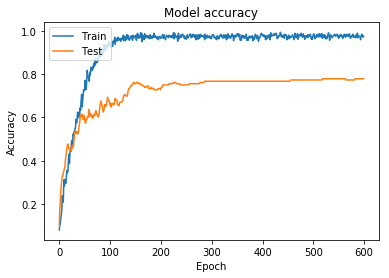

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Train and test on GT_split 2

In [16]:
Train = pickle.load(open(C.data_dir+"GT_train_2.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"GT_test_2.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 176/176 [00:00<00:00, 251.60it/s]


In [17]:
# Re-initialize weights, since training and testing data switch
AR_single = build_AR_single(C)

In [18]:
import keras
lr = 1e-3
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history=AR_single.fit([X_0,X_1],Y,
        batch_size=len(Y),
        epochs=600,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_test_0,X_test_1],Y_test)      
        )

Train on 433 samples, validate on 176 samples
Epoch 1/600
433/433 [==============================] - 11s 25ms/step - loss: 3.1036 - acc: 0.0693 - val_loss: 2.5870 - val_acc: 0.1136
Epoch 2/600
433/433 [==============================] - 0s 214us/step - loss: 3.0594 - acc: 0.0901 - val_loss: 2.4877 - val_acc: 0.1932
Epoch 3/600
433/433 [==============================] - 0s 196us/step - loss: 2.9347 - acc: 0.0855 - val_loss: 2.4061 - val_acc: 0.1989
Epoch 4/600
433/433 [==============================] - 0s 149us/step - loss: 2.7283 - acc: 0.1386 - val_loss: 2.3361 - val_acc: 0.2727
Epoch 5/600
433/433 [==============================] - 0s 152us/step - loss: 2.5750 - acc: 0.1871 - val_loss: 2.2922 - val_acc: 0.2955
Epoch 6/600
433/433 [==============================] - 0s 140us/step - loss: 2.5224 - acc: 0.2125 - val_loss: 2.2475 - val_acc: 0.3125
Epoch 7/600
433/433 [==============================] - 0s 161us/step - loss: 2.5220 - acc: 0.2102 - val_loss: 2.1990 - val_acc: 0.3580
Epoch 8/6

Epoch 61/600
433/433 [==============================] - 0s 170us/step - loss: 0.6507 - acc: 0.7968 - val_loss: 1.4647 - val_acc: 0.5398
Epoch 62/600
433/433 [==============================] - 0s 179us/step - loss: 0.5710 - acc: 0.8176 - val_loss: 1.5034 - val_acc: 0.5000
Epoch 63/600
433/433 [==============================] - 0s 177us/step - loss: 0.5749 - acc: 0.8430 - val_loss: 1.5225 - val_acc: 0.4886
Epoch 64/600
433/433 [==============================] - 0s 186us/step - loss: 0.6313 - acc: 0.8176 - val_loss: 1.5243 - val_acc: 0.5114
Epoch 65/600
433/433 [==============================] - 0s 164us/step - loss: 0.6153 - acc: 0.8199 - val_loss: 1.5144 - val_acc: 0.5114
Epoch 66/600
433/433 [==============================] - 0s 174us/step - loss: 0.6099 - acc: 0.8152 - val_loss: 1.4692 - val_acc: 0.5170
Epoch 67/600
433/433 [==============================] - 0s 184us/step - loss: 0.5073 - acc: 0.8591 - val_loss: 1.4356 - val_acc: 0.5227
Epoch 68/600
433/433 [==========================

433/433 [==============================] - 0s 190us/step - loss: 0.2269 - acc: 0.9492 - val_loss: 1.3440 - val_acc: 0.5966
Epoch 122/600
433/433 [==============================] - 0s 181us/step - loss: 0.1979 - acc: 0.9607 - val_loss: 1.3337 - val_acc: 0.6023
Epoch 123/600
433/433 [==============================] - 0s 171us/step - loss: 0.2041 - acc: 0.9584 - val_loss: 1.3229 - val_acc: 0.6023
Epoch 124/600
433/433 [==============================] - 0s 144us/step - loss: 0.2452 - acc: 0.9330 - val_loss: 1.3145 - val_acc: 0.6080
Epoch 125/600
433/433 [==============================] - 0s 174us/step - loss: 0.1818 - acc: 0.9769 - val_loss: 1.3063 - val_acc: 0.6080
Epoch 126/600
433/433 [==============================] - 0s 164us/step - loss: 0.2198 - acc: 0.9492 - val_loss: 1.2974 - val_acc: 0.6136
Epoch 127/600
433/433 [==============================] - 0s 140us/step - loss: 0.2385 - acc: 0.9515 - val_loss: 1.2865 - val_acc: 0.6250
Epoch 128/600
433/433 [==============================] 

Epoch 181/600
433/433 [==============================] - 0s 176us/step - loss: 0.1939 - acc: 0.9561 - val_loss: 1.0255 - val_acc: 0.6989
Epoch 182/600
433/433 [==============================] - 0s 174us/step - loss: 0.2085 - acc: 0.9515 - val_loss: 1.0234 - val_acc: 0.7045
Epoch 183/600
433/433 [==============================] - 0s 167us/step - loss: 0.1765 - acc: 0.9607 - val_loss: 1.0217 - val_acc: 0.7045
Epoch 184/600
433/433 [==============================] - 0s 140us/step - loss: 0.1884 - acc: 0.9607 - val_loss: 1.0196 - val_acc: 0.7045
Epoch 185/600
433/433 [==============================] - 0s 185us/step - loss: 0.1473 - acc: 0.9677 - val_loss: 1.0176 - val_acc: 0.7045
Epoch 186/600
433/433 [==============================] - 0s 172us/step - loss: 0.1926 - acc: 0.9654 - val_loss: 1.0157 - val_acc: 0.7102
Epoch 187/600
433/433 [==============================] - 0s 153us/step - loss: 0.1717 - acc: 0.9723 - val_loss: 1.0139 - val_acc: 0.7102
Epoch 188/600
433/433 [==================

Epoch 241/600
433/433 [==============================] - 0s 190us/step - loss: 0.2057 - acc: 0.9423 - val_loss: 0.9618 - val_acc: 0.7330
Epoch 242/600
433/433 [==============================] - 0s 185us/step - loss: 0.1763 - acc: 0.9677 - val_loss: 0.9612 - val_acc: 0.7330
Epoch 243/600
433/433 [==============================] - 0s 182us/step - loss: 0.1955 - acc: 0.9515 - val_loss: 0.9608 - val_acc: 0.7330
Epoch 244/600
433/433 [==============================] - 0s 190us/step - loss: 0.1755 - acc: 0.9723 - val_loss: 0.9605 - val_acc: 0.7330
Epoch 245/600
433/433 [==============================] - 0s 175us/step - loss: 0.1622 - acc: 0.9769 - val_loss: 0.9603 - val_acc: 0.7330
Epoch 246/600
433/433 [==============================] - 0s 173us/step - loss: 0.2140 - acc: 0.9515 - val_loss: 0.9599 - val_acc: 0.7330
Epoch 247/600
433/433 [==============================] - 0s 193us/step - loss: 0.2132 - acc: 0.9607 - val_loss: 0.9596 - val_acc: 0.7330
Epoch 248/600
433/433 [==================

Epoch 301/600
433/433 [==============================] - 0s 132us/step - loss: 0.1711 - acc: 0.9584 - val_loss: 0.9479 - val_acc: 0.7273
Epoch 302/600
433/433 [==============================] - 0s 158us/step - loss: 0.1944 - acc: 0.9446 - val_loss: 0.9481 - val_acc: 0.7273
Epoch 303/600
433/433 [==============================] - 0s 159us/step - loss: 0.2077 - acc: 0.9446 - val_loss: 0.9481 - val_acc: 0.7273
Epoch 304/600
433/433 [==============================] - 0s 150us/step - loss: 0.1830 - acc: 0.9607 - val_loss: 0.9479 - val_acc: 0.7273
Epoch 305/600
433/433 [==============================] - 0s 158us/step - loss: 0.1968 - acc: 0.9607 - val_loss: 0.9477 - val_acc: 0.7273
Epoch 306/600
433/433 [==============================] - 0s 147us/step - loss: 0.2155 - acc: 0.9515 - val_loss: 0.9475 - val_acc: 0.7273
Epoch 307/600
433/433 [==============================] - 0s 161us/step - loss: 0.1697 - acc: 0.9723 - val_loss: 0.9473 - val_acc: 0.7273
Epoch 308/600
433/433 [==================

Epoch 361/600
433/433 [==============================] - 0s 160us/step - loss: 0.1626 - acc: 0.9584 - val_loss: 0.9437 - val_acc: 0.7330
Epoch 362/600
433/433 [==============================] - 0s 138us/step - loss: 0.1708 - acc: 0.9607 - val_loss: 0.9435 - val_acc: 0.7330
Epoch 363/600
433/433 [==============================] - 0s 137us/step - loss: 0.1700 - acc: 0.9677 - val_loss: 0.9432 - val_acc: 0.7330
Epoch 364/600
433/433 [==============================] - 0s 136us/step - loss: 0.2035 - acc: 0.9561 - val_loss: 0.9431 - val_acc: 0.7330
Epoch 365/600
433/433 [==============================] - 0s 139us/step - loss: 0.1856 - acc: 0.9654 - val_loss: 0.9429 - val_acc: 0.7330
Epoch 366/600
433/433 [==============================] - 0s 145us/step - loss: 0.1646 - acc: 0.9584 - val_loss: 0.9427 - val_acc: 0.7330
Epoch 367/600
433/433 [==============================] - 0s 164us/step - loss: 0.1800 - acc: 0.9607 - val_loss: 0.9426 - val_acc: 0.7330
Epoch 368/600
433/433 [==================

Epoch 421/600
433/433 [==============================] - 0s 177us/step - loss: 0.1793 - acc: 0.9677 - val_loss: 0.9392 - val_acc: 0.7330
Epoch 422/600
433/433 [==============================] - 0s 171us/step - loss: 0.1879 - acc: 0.9607 - val_loss: 0.9391 - val_acc: 0.7330
Epoch 423/600
433/433 [==============================] - 0s 172us/step - loss: 0.1907 - acc: 0.9538 - val_loss: 0.9389 - val_acc: 0.7330
Epoch 424/600
433/433 [==============================] - 0s 163us/step - loss: 0.1871 - acc: 0.9492 - val_loss: 0.9388 - val_acc: 0.7330
Epoch 425/600
433/433 [==============================] - 0s 187us/step - loss: 0.1851 - acc: 0.9538 - val_loss: 0.9387 - val_acc: 0.7330
Epoch 426/600
433/433 [==============================] - 0s 172us/step - loss: 0.1610 - acc: 0.9700 - val_loss: 0.9386 - val_acc: 0.7330
Epoch 427/600
433/433 [==============================] - 0s 162us/step - loss: 0.1940 - acc: 0.9654 - val_loss: 0.9386 - val_acc: 0.7330
Epoch 428/600
433/433 [==================

Epoch 481/600
433/433 [==============================] - 0s 175us/step - loss: 0.1690 - acc: 0.9700 - val_loss: 0.9387 - val_acc: 0.7386
Epoch 482/600
433/433 [==============================] - 0s 165us/step - loss: 0.1756 - acc: 0.9561 - val_loss: 0.9388 - val_acc: 0.7386
Epoch 483/600
433/433 [==============================] - 0s 172us/step - loss: 0.2022 - acc: 0.9654 - val_loss: 0.9389 - val_acc: 0.7386
Epoch 484/600
433/433 [==============================] - 0s 163us/step - loss: 0.1969 - acc: 0.9584 - val_loss: 0.9391 - val_acc: 0.7386
Epoch 485/600
433/433 [==============================] - 0s 161us/step - loss: 0.1863 - acc: 0.9607 - val_loss: 0.9391 - val_acc: 0.7386
Epoch 486/600
433/433 [==============================] - 0s 165us/step - loss: 0.2156 - acc: 0.9492 - val_loss: 0.9390 - val_acc: 0.7386
Epoch 487/600
433/433 [==============================] - 0s 158us/step - loss: 0.1844 - acc: 0.9607 - val_loss: 0.9390 - val_acc: 0.7386
Epoch 488/600
433/433 [==================

Epoch 541/600
433/433 [==============================] - 0s 183us/step - loss: 0.1442 - acc: 0.9769 - val_loss: 0.9403 - val_acc: 0.7443
Epoch 542/600
433/433 [==============================] - 0s 171us/step - loss: 0.2002 - acc: 0.9492 - val_loss: 0.9404 - val_acc: 0.7443
Epoch 543/600
433/433 [==============================] - 0s 168us/step - loss: 0.1754 - acc: 0.9677 - val_loss: 0.9406 - val_acc: 0.7443
Epoch 544/600
433/433 [==============================] - 0s 165us/step - loss: 0.1800 - acc: 0.9654 - val_loss: 0.9409 - val_acc: 0.7443
Epoch 545/600
433/433 [==============================] - 0s 186us/step - loss: 0.1702 - acc: 0.9607 - val_loss: 0.9410 - val_acc: 0.7443
Epoch 546/600
433/433 [==============================] - 0s 165us/step - loss: 0.1551 - acc: 0.9677 - val_loss: 0.9410 - val_acc: 0.7443
Epoch 547/600
433/433 [==============================] - 0s 190us/step - loss: 0.1849 - acc: 0.9607 - val_loss: 0.9409 - val_acc: 0.7443
Epoch 548/600
433/433 [==================

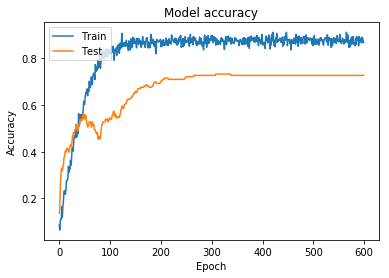

In [38]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Train and test on GT_split 3

In [19]:
Train = pickle.load(open(C.data_dir+"GT_train_3.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"GT_test_3.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 175/175 [00:00<00:00, 270.06it/s]


In [20]:
# Re-initialize weights, since training and testing data switch
AR_single = build_AR_single(C)

In [21]:
import keras
lr = 1e-3
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history=AR_single.fit([X_0,X_1],Y,
        batch_size=len(Y),
        epochs=500,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_test_0,X_test_1],Y_test)      
        )

lr = 1e-3
AR_single.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history=AR_single.fit([X_0,X_1],Y,
        batch_size=len(Y),
        epochs=500,
        verbose=True,
        shuffle=True,
        callbacks=[lrScheduler],
        validation_data=([X_test_0,X_test_1],Y_test)      
        )

Train on 434 samples, validate on 175 samples
Epoch 1/500
434/434 [==============================] - 12s 29ms/step - loss: 3.4932 - acc: 0.0737 - val_loss: 2.6705 - val_acc: 0.0971
Epoch 2/500
434/434 [==============================] - 0s 172us/step - loss: 3.3579 - acc: 0.0945 - val_loss: 2.5422 - val_acc: 0.1486
Epoch 3/500
434/434 [==============================] - 0s 172us/step - loss: 2.9928 - acc: 0.1221 - val_loss: 2.4313 - val_acc: 0.2286
Epoch 4/500
434/434 [==============================] - 0s 191us/step - loss: 2.8939 - acc: 0.1429 - val_loss: 2.3365 - val_acc: 0.2686
Epoch 5/500
434/434 [==============================] - 0s 143us/step - loss: 2.7569 - acc: 0.1912 - val_loss: 2.2647 - val_acc: 0.3029
Epoch 6/500
434/434 [==============================] - 0s 166us/step - loss: 2.5201 - acc: 0.1843 - val_loss: 2.2182 - val_acc: 0.3314
Epoch 7/500
434/434 [==============================] - 0s 168us/step - loss: 2.4525 - acc: 0.2097 - val_loss: 2.1880 - val_acc: 0.3371
Epoch 8/5

Epoch 61/500
434/434 [==============================] - 0s 180us/step - loss: 0.6126 - acc: 0.8364 - val_loss: 1.4522 - val_acc: 0.5657
Epoch 62/500
434/434 [==============================] - 0s 178us/step - loss: 0.5495 - acc: 0.8687 - val_loss: 1.4363 - val_acc: 0.5714
Epoch 63/500
434/434 [==============================] - 0s 173us/step - loss: 0.5144 - acc: 0.8618 - val_loss: 1.4269 - val_acc: 0.5714
Epoch 64/500
434/434 [==============================] - 0s 175us/step - loss: 0.5505 - acc: 0.8548 - val_loss: 1.4271 - val_acc: 0.5771
Epoch 65/500
434/434 [==============================] - 0s 178us/step - loss: 0.5250 - acc: 0.8410 - val_loss: 1.4325 - val_acc: 0.5714
Epoch 66/500
434/434 [==============================] - 0s 195us/step - loss: 0.5487 - acc: 0.8318 - val_loss: 1.4379 - val_acc: 0.5600
Epoch 67/500
434/434 [==============================] - 0s 184us/step - loss: 0.4852 - acc: 0.8733 - val_loss: 1.4345 - val_acc: 0.5771
Epoch 68/500
434/434 [==========================

434/434 [==============================] - 0s 168us/step - loss: 0.1837 - acc: 0.9631 - val_loss: 1.2072 - val_acc: 0.6971
Epoch 122/500
434/434 [==============================] - 0s 162us/step - loss: 0.1716 - acc: 0.9793 - val_loss: 1.2001 - val_acc: 0.7029
Epoch 123/500
434/434 [==============================] - 0s 169us/step - loss: 0.1836 - acc: 0.9608 - val_loss: 1.1965 - val_acc: 0.7086
Epoch 124/500
434/434 [==============================] - 0s 174us/step - loss: 0.1560 - acc: 0.9770 - val_loss: 1.1937 - val_acc: 0.7086
Epoch 125/500
434/434 [==============================] - 0s 167us/step - loss: 0.1746 - acc: 0.9700 - val_loss: 1.1906 - val_acc: 0.7029
Epoch 126/500
434/434 [==============================] - 0s 168us/step - loss: 0.1493 - acc: 0.9816 - val_loss: 1.1892 - val_acc: 0.7086
Epoch 127/500
434/434 [==============================] - 0s 157us/step - loss: 0.1929 - acc: 0.9516 - val_loss: 1.1862 - val_acc: 0.7029
Epoch 128/500
434/434 [==============================] 

Epoch 181/500
434/434 [==============================] - 0s 182us/step - loss: 0.1667 - acc: 0.9724 - val_loss: 1.0999 - val_acc: 0.7200
Epoch 182/500
434/434 [==============================] - 0s 174us/step - loss: 0.1355 - acc: 0.9747 - val_loss: 1.0995 - val_acc: 0.7200
Epoch 183/500
434/434 [==============================] - 0s 177us/step - loss: 0.1599 - acc: 0.9700 - val_loss: 1.0991 - val_acc: 0.7143
Epoch 184/500
434/434 [==============================] - 0s 172us/step - loss: 0.1701 - acc: 0.9700 - val_loss: 1.0988 - val_acc: 0.7143
Epoch 185/500
434/434 [==============================] - 0s 182us/step - loss: 0.1592 - acc: 0.9747 - val_loss: 1.0982 - val_acc: 0.7143
Epoch 186/500
434/434 [==============================] - 0s 188us/step - loss: 0.1392 - acc: 0.9770 - val_loss: 1.0980 - val_acc: 0.7143
Epoch 187/500
434/434 [==============================] - 0s 191us/step - loss: 0.1649 - acc: 0.9793 - val_loss: 1.0977 - val_acc: 0.7143
Epoch 188/500
434/434 [==================

Epoch 241/500
434/434 [==============================] - 0s 177us/step - loss: 0.1332 - acc: 0.9793 - val_loss: 1.0894 - val_acc: 0.7143
Epoch 242/500
434/434 [==============================] - 0s 208us/step - loss: 0.1771 - acc: 0.9585 - val_loss: 1.0894 - val_acc: 0.7143
Epoch 243/500
434/434 [==============================] - 0s 170us/step - loss: 0.1476 - acc: 0.9724 - val_loss: 1.0891 - val_acc: 0.7200
Epoch 244/500
434/434 [==============================] - 0s 169us/step - loss: 0.1492 - acc: 0.9770 - val_loss: 1.0889 - val_acc: 0.7200
Epoch 245/500
434/434 [==============================] - 0s 159us/step - loss: 0.1455 - acc: 0.9677 - val_loss: 1.0889 - val_acc: 0.7200
Epoch 246/500
434/434 [==============================] - 0s 172us/step - loss: 0.1515 - acc: 0.9816 - val_loss: 1.0887 - val_acc: 0.7200
Epoch 247/500
434/434 [==============================] - 0s 191us/step - loss: 0.1577 - acc: 0.9700 - val_loss: 1.0888 - val_acc: 0.7200
Epoch 248/500
434/434 [==================

Epoch 301/500
434/434 [==============================] - 0s 173us/step - loss: 0.1421 - acc: 0.9770 - val_loss: 1.0881 - val_acc: 0.7257
Epoch 302/500
434/434 [==============================] - 0s 159us/step - loss: 0.1767 - acc: 0.9608 - val_loss: 1.0881 - val_acc: 0.7257
Epoch 303/500
434/434 [==============================] - 0s 179us/step - loss: 0.1638 - acc: 0.9654 - val_loss: 1.0880 - val_acc: 0.7257
Epoch 304/500
434/434 [==============================] - 0s 168us/step - loss: 0.1925 - acc: 0.9539 - val_loss: 1.0879 - val_acc: 0.7257
Epoch 305/500
434/434 [==============================] - 0s 197us/step - loss: 0.1445 - acc: 0.9770 - val_loss: 1.0878 - val_acc: 0.7257
Epoch 306/500
434/434 [==============================] - 0s 180us/step - loss: 0.1561 - acc: 0.9793 - val_loss: 1.0878 - val_acc: 0.7257
Epoch 307/500
434/434 [==============================] - 0s 197us/step - loss: 0.1462 - acc: 0.9724 - val_loss: 1.0876 - val_acc: 0.7257
Epoch 308/500
434/434 [==================

Epoch 361/500
434/434 [==============================] - 0s 173us/step - loss: 0.1286 - acc: 0.9862 - val_loss: 1.0830 - val_acc: 0.7314
Epoch 362/500
434/434 [==============================] - 0s 176us/step - loss: 0.1313 - acc: 0.9816 - val_loss: 1.0830 - val_acc: 0.7314
Epoch 363/500
434/434 [==============================] - 0s 196us/step - loss: 0.1572 - acc: 0.9724 - val_loss: 1.0830 - val_acc: 0.7314
Epoch 364/500
434/434 [==============================] - 0s 180us/step - loss: 0.1459 - acc: 0.9747 - val_loss: 1.0832 - val_acc: 0.7314
Epoch 365/500
434/434 [==============================] - 0s 178us/step - loss: 0.1074 - acc: 0.9816 - val_loss: 1.0832 - val_acc: 0.7314
Epoch 366/500
434/434 [==============================] - 0s 165us/step - loss: 0.1496 - acc: 0.9724 - val_loss: 1.0832 - val_acc: 0.7314
Epoch 367/500
434/434 [==============================] - 0s 164us/step - loss: 0.1460 - acc: 0.9793 - val_loss: 1.0833 - val_acc: 0.7314
Epoch 368/500
434/434 [==================

Epoch 421/500
434/434 [==============================] - 0s 173us/step - loss: 0.1682 - acc: 0.9631 - val_loss: 1.0857 - val_acc: 0.7314
Epoch 422/500
434/434 [==============================] - 0s 170us/step - loss: 0.1544 - acc: 0.9747 - val_loss: 1.0861 - val_acc: 0.7314
Epoch 423/500
434/434 [==============================] - 0s 169us/step - loss: 0.1646 - acc: 0.9608 - val_loss: 1.0861 - val_acc: 0.7314
Epoch 424/500
434/434 [==============================] - 0s 161us/step - loss: 0.1707 - acc: 0.9677 - val_loss: 1.0863 - val_acc: 0.7314
Epoch 425/500
434/434 [==============================] - 0s 171us/step - loss: 0.1577 - acc: 0.9793 - val_loss: 1.0864 - val_acc: 0.7314
Epoch 426/500
434/434 [==============================] - 0s 167us/step - loss: 0.1755 - acc: 0.9747 - val_loss: 1.0866 - val_acc: 0.7314
Epoch 427/500
434/434 [==============================] - 0s 184us/step - loss: 0.1353 - acc: 0.9793 - val_loss: 1.0868 - val_acc: 0.7314
Epoch 428/500
434/434 [==================

Epoch 481/500
434/434 [==============================] - 0s 198us/step - loss: 0.1273 - acc: 0.9839 - val_loss: 1.0875 - val_acc: 0.7314
Epoch 482/500
434/434 [==============================] - 0s 189us/step - loss: 0.1419 - acc: 0.9770 - val_loss: 1.0875 - val_acc: 0.7314
Epoch 483/500
434/434 [==============================] - 0s 188us/step - loss: 0.1388 - acc: 0.9770 - val_loss: 1.0875 - val_acc: 0.7314
Epoch 484/500
434/434 [==============================] - 0s 170us/step - loss: 0.1314 - acc: 0.9770 - val_loss: 1.0876 - val_acc: 0.7314
Epoch 485/500
434/434 [==============================] - 0s 174us/step - loss: 0.1489 - acc: 0.9724 - val_loss: 1.0876 - val_acc: 0.7314
Epoch 486/500
434/434 [==============================] - 0s 139us/step - loss: 0.1252 - acc: 0.9816 - val_loss: 1.0876 - val_acc: 0.7314
Epoch 487/500
434/434 [==============================] - 0s 153us/step - loss: 0.1537 - acc: 0.9654 - val_loss: 1.0875 - val_acc: 0.7314
Epoch 488/500
434/434 [==================

Epoch 41/500
434/434 [==============================] - 0s 180us/step - loss: 0.0880 - acc: 0.9885 - val_loss: 1.3268 - val_acc: 0.7086
Epoch 42/500
434/434 [==============================] - 0s 193us/step - loss: 0.0589 - acc: 1.0000 - val_loss: 1.3180 - val_acc: 0.7143
Epoch 43/500
434/434 [==============================] - 0s 177us/step - loss: 0.0645 - acc: 0.9931 - val_loss: 1.3074 - val_acc: 0.7200
Epoch 44/500
434/434 [==============================] - 0s 169us/step - loss: 0.0871 - acc: 0.9816 - val_loss: 1.2983 - val_acc: 0.7257
Epoch 45/500
434/434 [==============================] - 0s 176us/step - loss: 0.0877 - acc: 0.9816 - val_loss: 1.2850 - val_acc: 0.7257
Epoch 46/500
434/434 [==============================] - 0s 176us/step - loss: 0.0909 - acc: 0.9747 - val_loss: 1.2715 - val_acc: 0.7257
Epoch 47/500
434/434 [==============================] - 0s 179us/step - loss: 0.0730 - acc: 0.9862 - val_loss: 1.2588 - val_acc: 0.7371
Epoch 48/500
434/434 [==========================

Epoch 102/500
434/434 [==============================] - 0s 177us/step - loss: 0.0676 - acc: 0.9885 - val_loss: 1.1603 - val_acc: 0.7486
Epoch 103/500
434/434 [==============================] - 0s 157us/step - loss: 0.0627 - acc: 0.9954 - val_loss: 1.1594 - val_acc: 0.7486
Epoch 104/500
434/434 [==============================] - 0s 157us/step - loss: 0.0520 - acc: 0.9977 - val_loss: 1.1585 - val_acc: 0.7486
Epoch 105/500
434/434 [==============================] - 0s 174us/step - loss: 0.0659 - acc: 0.9908 - val_loss: 1.1577 - val_acc: 0.7486
Epoch 106/500
434/434 [==============================] - 0s 159us/step - loss: 0.0653 - acc: 0.9885 - val_loss: 1.1567 - val_acc: 0.7486
Epoch 107/500
434/434 [==============================] - 0s 170us/step - loss: 0.0707 - acc: 0.9839 - val_loss: 1.1559 - val_acc: 0.7486
Epoch 108/500
434/434 [==============================] - 0s 178us/step - loss: 0.0602 - acc: 0.9931 - val_loss: 1.1551 - val_acc: 0.7486
Epoch 109/500
434/434 [==================

Epoch 162/500
434/434 [==============================] - 0s 157us/step - loss: 0.0477 - acc: 0.9977 - val_loss: 1.1375 - val_acc: 0.7600
Epoch 163/500
434/434 [==============================] - 0s 150us/step - loss: 0.0735 - acc: 0.9885 - val_loss: 1.1375 - val_acc: 0.7600
Epoch 164/500
434/434 [==============================] - 0s 184us/step - loss: 0.0684 - acc: 0.9931 - val_loss: 1.1374 - val_acc: 0.7600
Epoch 165/500
434/434 [==============================] - 0s 185us/step - loss: 0.0669 - acc: 0.9862 - val_loss: 1.1374 - val_acc: 0.7600
Epoch 166/500
434/434 [==============================] - 0s 157us/step - loss: 0.0699 - acc: 0.9839 - val_loss: 1.1372 - val_acc: 0.7600
Epoch 167/500
434/434 [==============================] - 0s 172us/step - loss: 0.0671 - acc: 0.9885 - val_loss: 1.1371 - val_acc: 0.7600
Epoch 168/500
434/434 [==============================] - 0s 180us/step - loss: 0.0610 - acc: 0.9954 - val_loss: 1.1373 - val_acc: 0.7600
Epoch 169/500
434/434 [==================

Epoch 222/500
434/434 [==============================] - 0s 192us/step - loss: 0.0741 - acc: 0.9793 - val_loss: 1.1373 - val_acc: 0.7600
Epoch 223/500
434/434 [==============================] - 0s 215us/step - loss: 0.0639 - acc: 0.9885 - val_loss: 1.1374 - val_acc: 0.7600
Epoch 224/500
434/434 [==============================] - 0s 163us/step - loss: 0.0669 - acc: 0.9908 - val_loss: 1.1374 - val_acc: 0.7600
Epoch 225/500
434/434 [==============================] - 0s 203us/step - loss: 0.0652 - acc: 0.9908 - val_loss: 1.1373 - val_acc: 0.7600
Epoch 226/500
434/434 [==============================] - 0s 186us/step - loss: 0.0489 - acc: 0.9977 - val_loss: 1.1372 - val_acc: 0.7600
Epoch 227/500
434/434 [==============================] - 0s 183us/step - loss: 0.0472 - acc: 1.0000 - val_loss: 1.1373 - val_acc: 0.7600
Epoch 228/500
434/434 [==============================] - 0s 202us/step - loss: 0.0834 - acc: 0.9839 - val_loss: 1.1373 - val_acc: 0.7600
Epoch 229/500
434/434 [==================

Epoch 282/500
434/434 [==============================] - 0s 160us/step - loss: 0.0660 - acc: 0.9931 - val_loss: 1.1444 - val_acc: 0.7543
Epoch 283/500
434/434 [==============================] - 0s 147us/step - loss: 0.0483 - acc: 0.9954 - val_loss: 1.1443 - val_acc: 0.7543
Epoch 284/500
434/434 [==============================] - 0s 169us/step - loss: 0.0739 - acc: 0.9816 - val_loss: 1.1442 - val_acc: 0.7543
Epoch 285/500
434/434 [==============================] - 0s 177us/step - loss: 0.0549 - acc: 0.9908 - val_loss: 1.1438 - val_acc: 0.7543
Epoch 286/500
434/434 [==============================] - 0s 155us/step - loss: 0.0591 - acc: 0.9908 - val_loss: 1.1438 - val_acc: 0.7543
Epoch 287/500
434/434 [==============================] - 0s 162us/step - loss: 0.0607 - acc: 0.9885 - val_loss: 1.1436 - val_acc: 0.7543
Epoch 288/500
434/434 [==============================] - 0s 159us/step - loss: 0.0655 - acc: 0.9908 - val_loss: 1.1434 - val_acc: 0.7543
Epoch 289/500
434/434 [==================

Epoch 342/500
434/434 [==============================] - 0s 154us/step - loss: 0.0624 - acc: 0.9885 - val_loss: 1.1411 - val_acc: 0.7486
Epoch 343/500
434/434 [==============================] - 0s 155us/step - loss: 0.0608 - acc: 0.9931 - val_loss: 1.1411 - val_acc: 0.7486
Epoch 344/500
434/434 [==============================] - 0s 166us/step - loss: 0.0467 - acc: 0.9931 - val_loss: 1.1409 - val_acc: 0.7486
Epoch 345/500
434/434 [==============================] - 0s 162us/step - loss: 0.0835 - acc: 0.9816 - val_loss: 1.1410 - val_acc: 0.7486
Epoch 346/500
434/434 [==============================] - 0s 154us/step - loss: 0.0616 - acc: 0.9885 - val_loss: 1.1410 - val_acc: 0.7486
Epoch 347/500
434/434 [==============================] - 0s 179us/step - loss: 0.0575 - acc: 0.9931 - val_loss: 1.1412 - val_acc: 0.7486
Epoch 348/500
434/434 [==============================] - 0s 161us/step - loss: 0.0562 - acc: 0.9931 - val_loss: 1.1413 - val_acc: 0.7486
Epoch 349/500
434/434 [==================

Epoch 402/500
434/434 [==============================] - 0s 173us/step - loss: 0.0509 - acc: 1.0000 - val_loss: 1.1478 - val_acc: 0.7486
Epoch 403/500
434/434 [==============================] - 0s 202us/step - loss: 0.0444 - acc: 0.9977 - val_loss: 1.1480 - val_acc: 0.7486
Epoch 404/500
434/434 [==============================] - 0s 167us/step - loss: 0.0753 - acc: 0.9908 - val_loss: 1.1480 - val_acc: 0.7486
Epoch 405/500
434/434 [==============================] - 0s 181us/step - loss: 0.0557 - acc: 0.9908 - val_loss: 1.1481 - val_acc: 0.7486
Epoch 406/500
434/434 [==============================] - 0s 170us/step - loss: 0.0590 - acc: 0.9862 - val_loss: 1.1481 - val_acc: 0.7486
Epoch 407/500
434/434 [==============================] - 0s 171us/step - loss: 0.0771 - acc: 0.9885 - val_loss: 1.1481 - val_acc: 0.7486
Epoch 408/500
434/434 [==============================] - 0s 163us/step - loss: 0.0612 - acc: 0.9908 - val_loss: 1.1482 - val_acc: 0.7486
Epoch 409/500
434/434 [==================

Epoch 462/500
434/434 [==============================] - 0s 161us/step - loss: 0.0577 - acc: 0.9862 - val_loss: 1.1466 - val_acc: 0.7486
Epoch 463/500
434/434 [==============================] - 0s 168us/step - loss: 0.0680 - acc: 0.9839 - val_loss: 1.1470 - val_acc: 0.7486
Epoch 464/500
434/434 [==============================] - 0s 166us/step - loss: 0.0657 - acc: 0.9908 - val_loss: 1.1472 - val_acc: 0.7486
Epoch 465/500
434/434 [==============================] - 0s 191us/step - loss: 0.0589 - acc: 0.9908 - val_loss: 1.1472 - val_acc: 0.7486
Epoch 466/500
434/434 [==============================] - 0s 188us/step - loss: 0.0525 - acc: 0.9931 - val_loss: 1.1470 - val_acc: 0.7486
Epoch 467/500
434/434 [==============================] - 0s 164us/step - loss: 0.0647 - acc: 0.9908 - val_loss: 1.1474 - val_acc: 0.7486
Epoch 468/500
434/434 [==============================] - 0s 156us/step - loss: 0.0492 - acc: 0.9977 - val_loss: 1.1475 - val_acc: 0.7486
Epoch 469/500
434/434 [==================

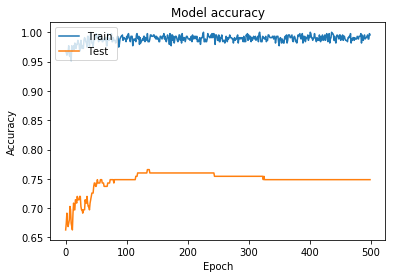

In [22]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Calculate average 

In [23]:
(0.78+0.74+0.75)/3

0.7566666666666667